# 📈 U.S. Inflation Forecasting Model

**Author:** Jason Finkle  
**Date:** January 2026  

This project builds and compares multiple time series forecasting models to predict U.S. inflation using the Consumer Price Index (CPI) data from the Federal Reserve Economic Data (FRED) API.

## Models Implemented:
- **Holt-Winters Exponential Smoothing** - Triple exponential smoothing with seasonality
- **XGBoost** - Gradient boosting with engineered lag features
- **LSTM Neural Network** - Deep learning approach for sequence prediction

---

## 1. Setup and Configuration

In [8]:
# Install required packages
%pip install fredapi xgboost tensorflow statsmodels scikit-learn seaborn plotly -q

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
os.makedirs('figures', exist_ok=True)
# Data retrieval
from fredapi import Fred

# Statistical analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for consistent styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#C73E1D',
    'dark': '#3B3B3B'
}

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Acquisition from FRED API

In [9]:
# Initialize FRED API (replace with your API key)
# Get your free API key at: https://fred.stlouisfed.org/docs/api/api_key.html
FRED_API_KEY = "YOUR KEY HERE"  # Replace with your key
fred = Fred(api_key=FRED_API_KEY)

# Download CPI data (Consumer Price Index for All Urban Consumers)
cpi_data = fred.get_series('CPIAUCSL')
print(f"✅ Downloaded CPI data: {len(cpi_data)} observations")
print(f"   Date range: {cpi_data.index[0].strftime('%Y-%m-%d')} to {cpi_data.index[-1].strftime('%Y-%m-%d')}")

✅ Downloaded CPI data: 948 observations
   Date range: 1947-01-01 to 2025-12-01


In [10]:
# Download additional economic indicators
economic_indicators = {
    'CPI': 'CPIAUCSL',
    'PPI': 'PPIACO',              # Producer Price Index
    'Unemployment': 'UNRATE',      # Unemployment Rate
    'M2': 'M2SL',                  # Money Supply M2
    'Fed_Funds': 'FEDFUNDS',       # Federal Funds Rate
    'GDP': 'GDP'                   # Gross Domestic Product
}

# Download all series
econ_data = {}
for name, series_id in economic_indicators.items():
    try:
        econ_data[name] = fred.get_series(series_id)
        print(f"✅ {name}: {len(econ_data[name])} observations")
    except Exception as e:
        print(f"❌ {name}: Failed to download - {e}")

# Combine into DataFrame
econ_df = pd.DataFrame(econ_data)
econ_df.index = pd.to_datetime(econ_df.index)
econ_df = econ_df.dropna()

print(f"\n📊 Combined dataset: {len(econ_df)} complete observations")

✅ CPI: 948 observations
✅ PPI: 1355 observations
✅ Unemployment: 936 observations
✅ M2: 803 observations
✅ Fed_Funds: 858 observations
✅ GDP: 319 observations

📊 Combined dataset: 267 complete observations


## 3. Exploratory Data Analysis (EDA)

### 3.1 Historical CPI Trend with Key Economic Events

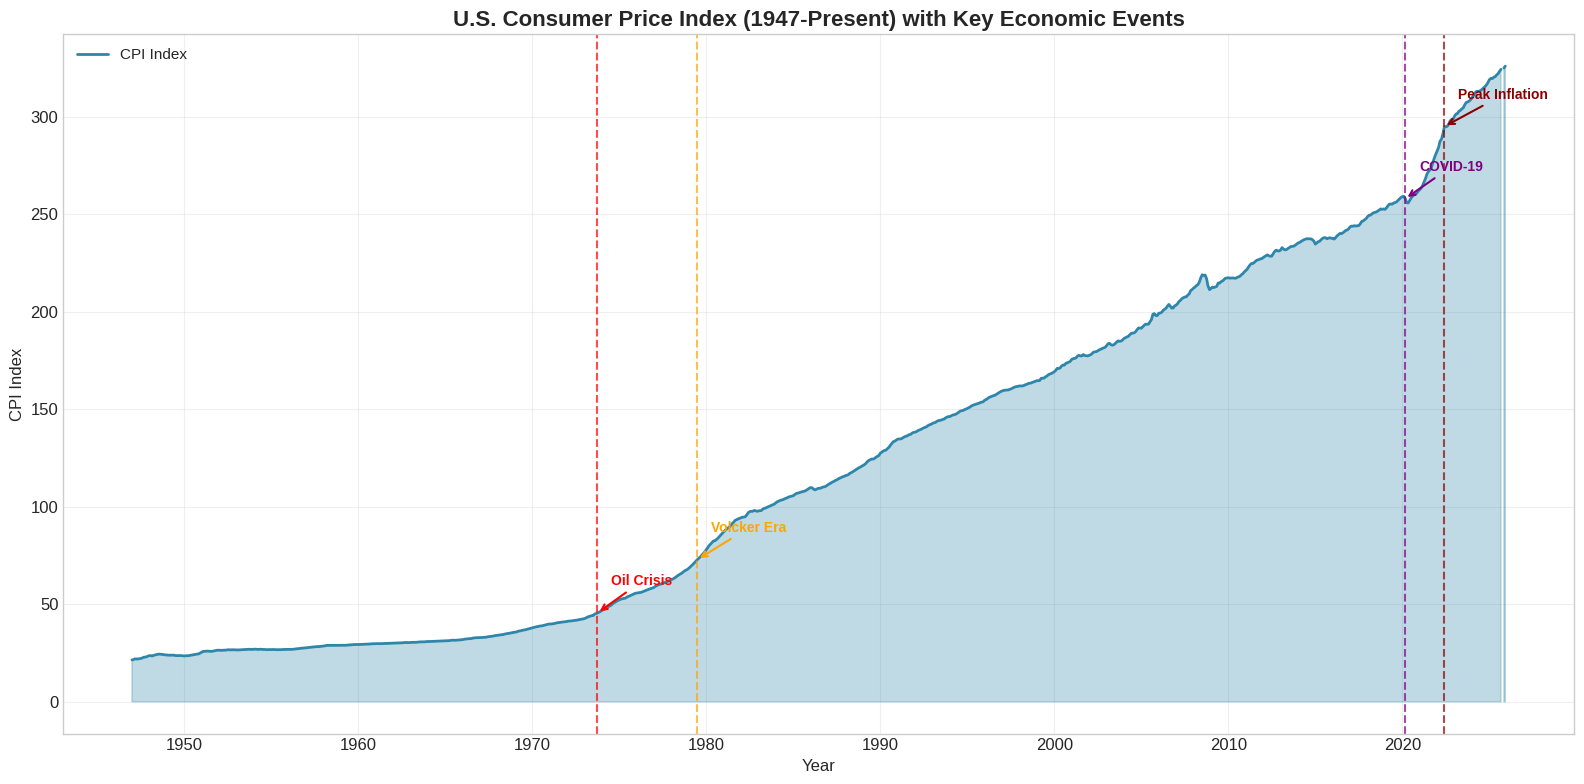

📈 Figure saved: figures/01_cpi_historical_trend.png


In [11]:
# Create main DataFrame
inflation_df = pd.DataFrame({'CPI': cpi_data})
inflation_df.index = pd.to_datetime(inflation_df.index)

# Calculate Year-over-Year inflation rate
inflation_df['Inflation_Rate'] = inflation_df['CPI'].pct_change(periods=12) * 100

# Plot historical CPI with economic events
fig, ax = plt.subplots(figsize=(16, 8))

# Main CPI plot
ax.plot(inflation_df.index, inflation_df['CPI'], color=COLORS['primary'], linewidth=2, label='CPI Index')
ax.fill_between(inflation_df.index, inflation_df['CPI'], alpha=0.3, color=COLORS['primary'])

# Annotate key economic events
events = {
    '1973-10-01': ('Oil Crisis', 'red'),
    '1979-07-01': ('Volcker Era', 'orange'),
    '2008-09-15': ('Financial Crisis', 'red'),
    '2020-03-01': ('COVID-19', 'purple'),
    '2022-06-01': ('Peak Inflation', 'darkred')
}

for date, (event, color) in events.items():
    event_date = pd.to_datetime(date)
    if event_date in inflation_df.index:
        ax.axvline(x=event_date, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
        y_pos = inflation_df.loc[event_date, 'CPI']
        ax.annotate(event, xy=(event_date, y_pos), xytext=(10, 20),
                   textcoords='offset points', fontsize=10, fontweight='bold',
                   color=color, ha='left',
                   arrowprops=dict(arrowstyle='->', color=color, lw=1.5))

ax.set_title('U.S. Consumer Price Index (1947-Present) with Key Economic Events', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CPI Index', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/01_cpi_historical_trend.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/01_cpi_historical_trend.png")

### 3.2 Year-over-Year Inflation Rate

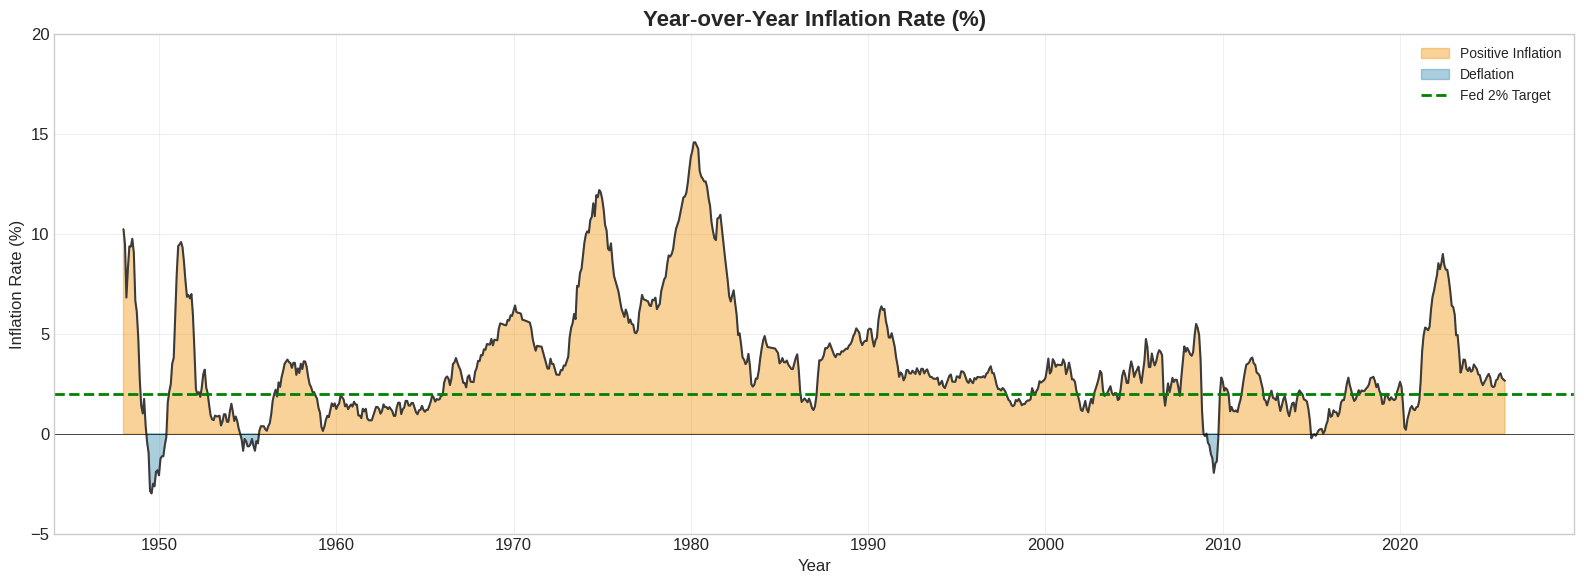

📈 Figure saved: figures/02_yoy_inflation_rate.png


In [12]:
# Plot YoY Inflation Rate
fig, ax = plt.subplots(figsize=(16, 6))

# Create color gradient based on inflation level
colors = ['green' if x < 2 else 'orange' if x < 5 else 'red' for x in inflation_df['Inflation_Rate'].dropna()]

ax.fill_between(inflation_df.index[12:], 0, inflation_df['Inflation_Rate'].dropna(),
                where=inflation_df['Inflation_Rate'].dropna() >= 0,
                color=COLORS['accent'], alpha=0.4, label='Positive Inflation')
ax.fill_between(inflation_df.index[12:], 0, inflation_df['Inflation_Rate'].dropna(),
                where=inflation_df['Inflation_Rate'].dropna() < 0,
                color=COLORS['primary'], alpha=0.4, label='Deflation')
ax.plot(inflation_df.index[12:], inflation_df['Inflation_Rate'].dropna(),
        color=COLORS['dark'], linewidth=1.5)

# Add 2% target line
ax.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Fed 2% Target')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_title('Year-over-Year Inflation Rate (%)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Inflation Rate (%)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(-5, 20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/02_yoy_inflation_rate.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/02_yoy_inflation_rate.png")

### 3.3 Seasonal Decomposition

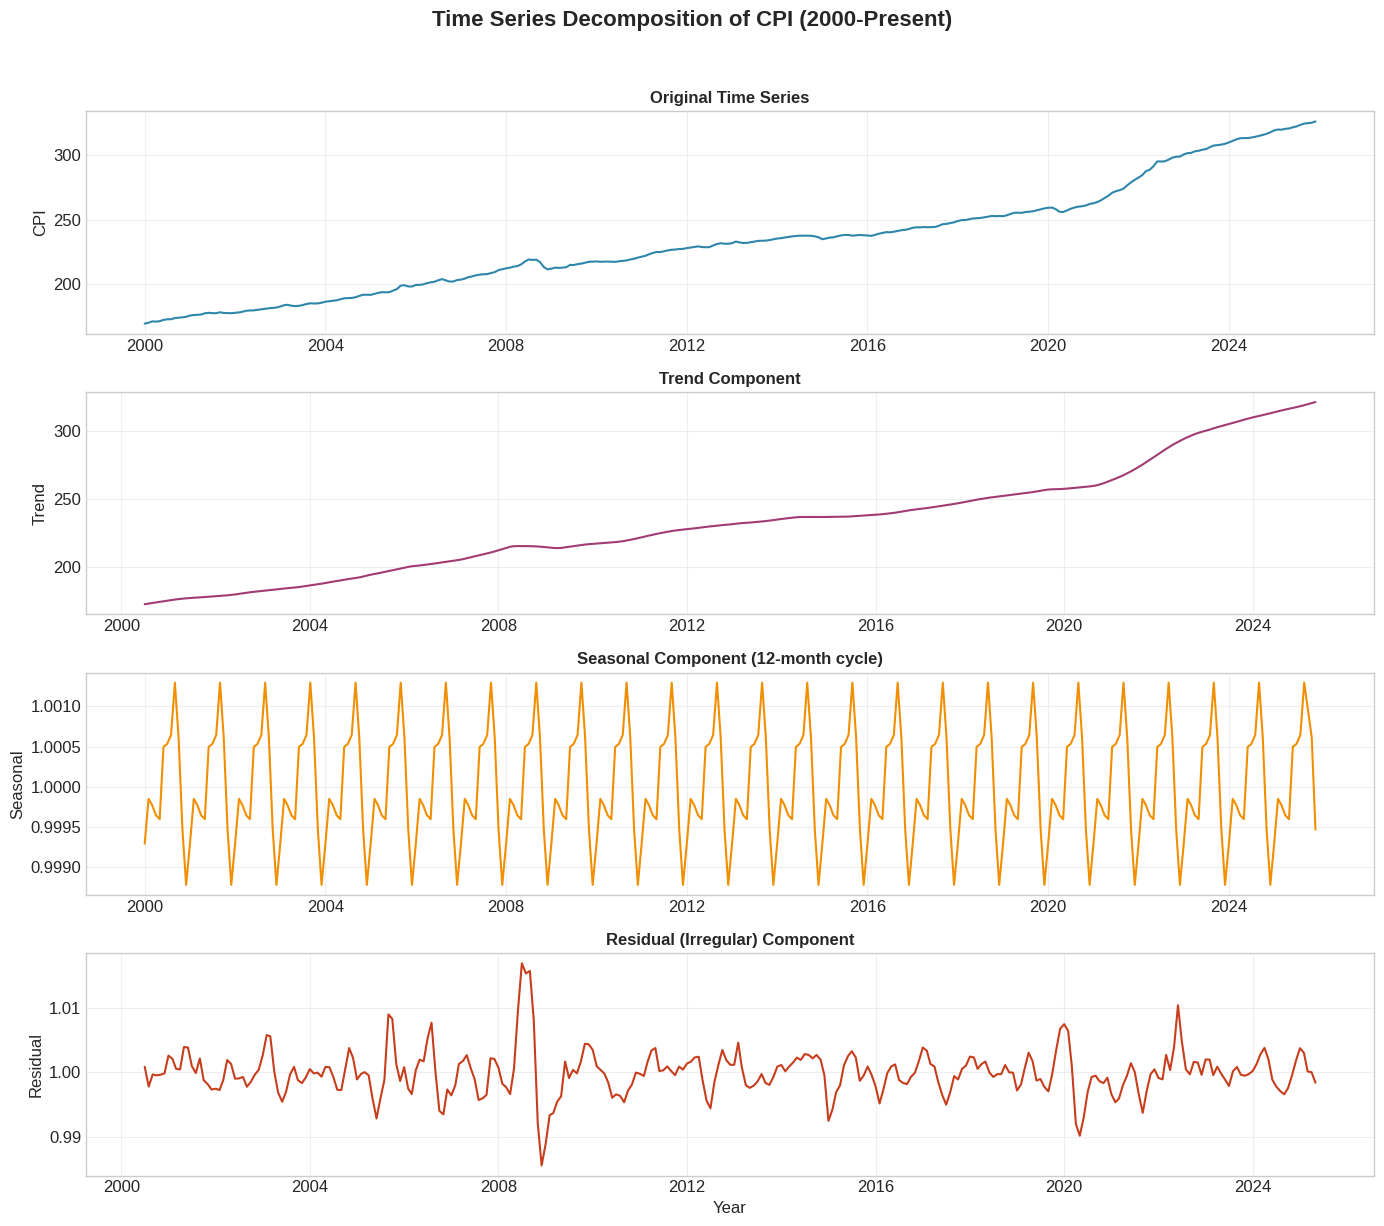

📈 Figure saved: figures/03_seasonal_decomposition.png


In [13]:
# Perform seasonal decomposition (use recent data for clearer patterns)
recent_cpi = inflation_df['CPI']['2000':].dropna()
decomposition = seasonal_decompose(recent_cpi, model='multiplicative', period=12)

# Create decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(decomposition.observed, color=COLORS['primary'], linewidth=1.5)
axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('CPI')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend, color=COLORS['secondary'], linewidth=1.5)
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal, color=COLORS['accent'], linewidth=1.5)
axes[2].set_title('Seasonal Component (12-month cycle)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid, color=COLORS['success'], linewidth=1.5)
axes[3].set_title('Residual (Irregular) Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Year')
axes[3].grid(True, alpha=0.3)

plt.suptitle('Time Series Decomposition of CPI (2000-Present)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/03_seasonal_decomposition.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/03_seasonal_decomposition.png")

### 3.4 Correlation Heatmap of Economic Indicators

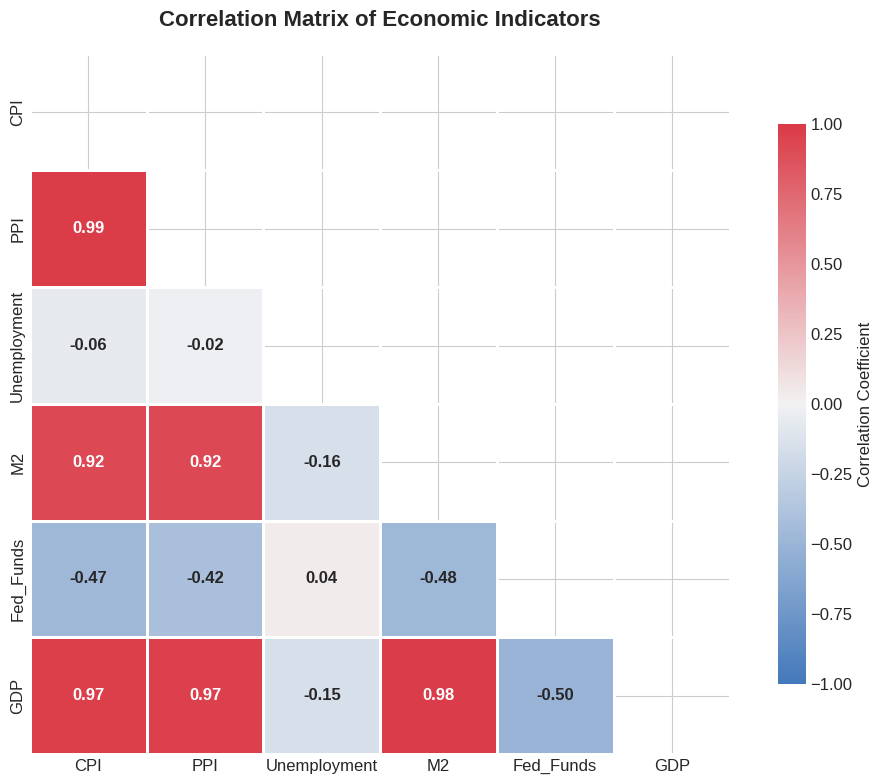

📈 Figure saved: figures/04_correlation_heatmap.png


In [14]:
# Calculate correlation matrix
corr_matrix = econ_df.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=2, annot=True, fmt='.2f',
            annot_kws={'size': 12, 'fontweight': 'bold'},
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'})

ax.set_title('Correlation Matrix of Economic Indicators', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('figures/04_correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/04_correlation_heatmap.png")

### 3.5 ACF and PACF Plots

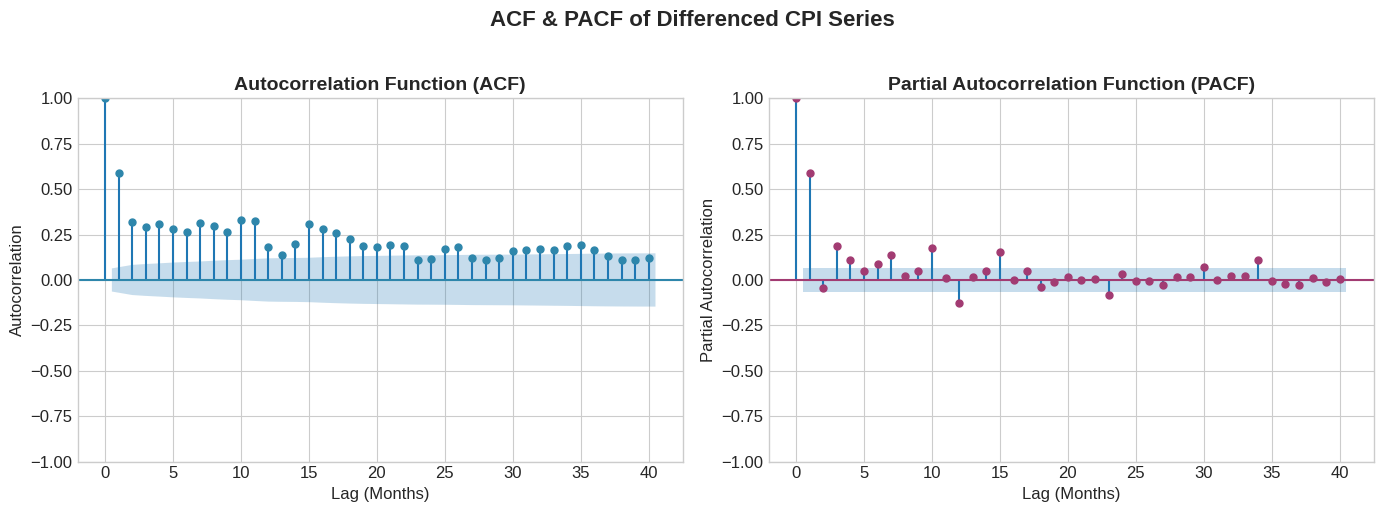

📈 Figure saved: figures/05_acf_pacf_plots.png


In [15]:
# ACF and PACF plots for model selection
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Difference the series for stationarity
cpi_diff = inflation_df['CPI'].diff().dropna()

# ACF
plot_acf(cpi_diff, ax=axes[0], lags=40, color=COLORS['primary'])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (Months)')
axes[0].set_ylabel('Autocorrelation')

# PACF
plot_pacf(cpi_diff, ax=axes[1], lags=40, color=COLORS['secondary'])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (Months)')
axes[1].set_ylabel('Partial Autocorrelation')

plt.suptitle('ACF & PACF of Differenced CPI Series', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/05_acf_pacf_plots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/05_acf_pacf_plots.png")

## 4. Data Preprocessing and Train/Test Split

In [16]:
# Define forecast horizon
n_periods = 12  # Forecast 12 months ahead

# Create time series
inflation_ts = inflation_df['CPI'].dropna()

# Train/Test split
train_data = inflation_ts[:-n_periods]
test_data = inflation_ts[-n_periods:]

print(f"📊 Data Split Summary:")
print(f"   Training set: {len(train_data)} observations ({train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')})")
print(f"   Test set: {len(test_data)} observations ({test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')})")

📊 Data Split Summary:
   Training set: 935 observations (1947-01 to 2024-11)
   Test set: 12 observations (2024-12 to 2025-12)


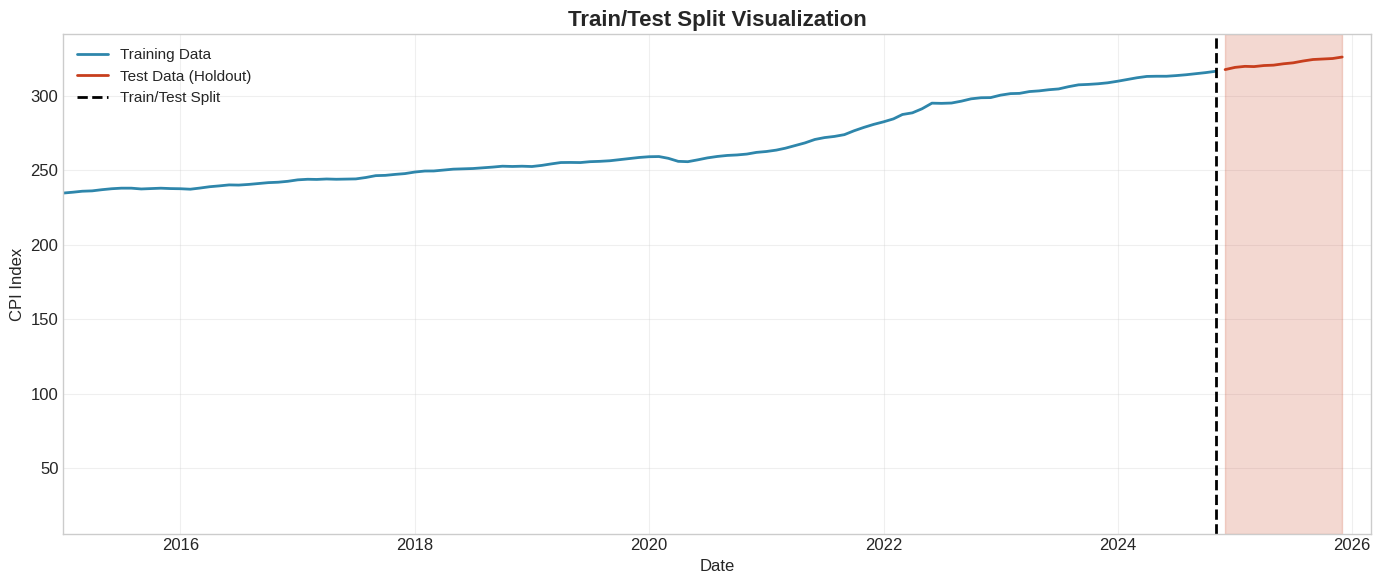

📈 Figure saved: figures/06_train_test_split.png


In [17]:
# Visualize train/test split
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data, color=COLORS['primary'], linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data, color=COLORS['success'], linewidth=2, label='Test Data (Holdout)')

# Add vertical line at split point
ax.axvline(x=train_data.index[-1], color='black', linestyle='--', linewidth=2, label='Train/Test Split')

# Shade test region
ax.axvspan(test_data.index[0], test_data.index[-1], alpha=0.2, color=COLORS['success'])

ax.set_title('Train/Test Split Visualization', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CPI Index', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Zoom to recent years
ax.set_xlim(pd.Timestamp('2015-01-01'), inflation_ts.index[-1] + pd.DateOffset(months=3))

plt.tight_layout()
plt.savefig('figures/06_train_test_split.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/06_train_test_split.png")

## 5. Model Training

### 5.1 Holt-Winters Exponential Smoothing

In [18]:
# Fit Holt-Winters model
print("🔄 Training Holt-Winters model...")

hw_model = ExponentialSmoothing(
    train_data,
    seasonal='add',
    seasonal_periods=12,
    trend='add',
    damped_trend=True
).fit(optimized=True)

# Generate predictions
hw_predictions = hw_model.forecast(n_periods)
hw_predictions.index = test_data.index

# Evaluate
mse_hw = mean_squared_error(test_data, hw_predictions)
mae_hw = mean_absolute_error(test_data, hw_predictions)
mape_hw = mean_absolute_percentage_error(test_data, hw_predictions) * 100

print(f"✅ Holt-Winters Model Results:")
print(f"   MSE:  {mse_hw:.4f}")
print(f"   MAE:  {mae_hw:.4f}")
print(f"   MAPE: {mape_hw:.2f}%")

🔄 Training Holt-Winters model...
✅ Holt-Winters Model Results:
   MSE:  10.6182
   MAE:  2.7283
   MAPE: 0.84%


### 5.2 XGBoost with Feature Engineering

In [19]:
# Feature engineering for XGBoost
print("🔄 Engineering features for XGBoost...")

xgb_df = pd.DataFrame({'CPI': inflation_ts})

# Lag features
for lag in range(1, 13):
    xgb_df[f'lag_{lag}'] = xgb_df['CPI'].shift(lag)

# Rolling statistics
for window in [3, 6, 12]:
    xgb_df[f'rolling_mean_{window}'] = xgb_df['CPI'].rolling(window=window).mean()
    xgb_df[f'rolling_std_{window}'] = xgb_df['CPI'].rolling(window=window).std()

# Time-based features
xgb_df['month'] = xgb_df.index.month
xgb_df['year'] = xgb_df.index.year
xgb_df['quarter'] = xgb_df.index.quarter

# Drop NaN rows
xgb_df = xgb_df.dropna()

print(f"   Created {len(xgb_df.columns)-1} features")

# Split data
train_size = len(xgb_df) - n_periods
X_train = xgb_df.iloc[:train_size].drop('CPI', axis=1)
y_train = xgb_df.iloc[:train_size]['CPI']
X_test = xgb_df.iloc[train_size:].drop('CPI', axis=1)
y_test = xgb_df.iloc[train_size:]['CPI']

🔄 Engineering features for XGBoost...
   Created 21 features


In [20]:
# Train XGBoost model
print("🔄 Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, xgb_predictions)
mae_xgb = mean_absolute_error(y_test, xgb_predictions)
mape_xgb = mean_absolute_percentage_error(y_test, xgb_predictions) * 100

print(f"✅ XGBoost Model Results:")
print(f"   MSE:  {mse_xgb:.4f}")
print(f"   MAE:  {mae_xgb:.4f}")
print(f"   MAPE: {mape_xgb:.2f}%")

🔄 Training XGBoost model...
✅ XGBoost Model Results:
   MSE:  49.7869
   MAE:  6.6068
   MAPE: 2.05%


### 5.3 LSTM Neural Network

In [21]:
# Prepare data for LSTM
print("🔄 Preparing data for LSTM...")

lookback = 12

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(inflation_ts.values.reshape(-1, 1))

# Create sequences
X_lstm, y_lstm = [], []
for i in range(len(scaled_data) - lookback):
    X_lstm.append(scaled_data[i:(i + lookback), 0])
    y_lstm.append(scaled_data[i + lookback, 0])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Reshape for LSTM [samples, timesteps, features]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Split
train_size_lstm = len(X_lstm) - n_periods
X_train_lstm = X_lstm[:train_size_lstm]
y_train_lstm = y_lstm[:train_size_lstm]
X_test_lstm = X_lstm[train_size_lstm:]
y_test_lstm = y_lstm[train_size_lstm:]

print(f"   Training samples: {X_train_lstm.shape[0]}")
print(f"   Test samples: {X_test_lstm.shape[0]}")

🔄 Preparing data for LSTM...
   Training samples: 923
   Test samples: 12


In [22]:
# Build and train LSTM
print("🔄 Training LSTM model...")

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# Predictions
lstm_predictions_scaled = lstm_model.predict(X_test_lstm, verbose=0)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled).flatten()
y_test_lstm_original = scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()

# Evaluate
mse_lstm = mean_squared_error(y_test_lstm_original, lstm_predictions)
mae_lstm = mean_absolute_error(y_test_lstm_original, lstm_predictions)
mape_lstm = mean_absolute_percentage_error(y_test_lstm_original, lstm_predictions) * 100

print(f"✅ LSTM Model Results:")
print(f"   MSE:  {mse_lstm:.4f}")
print(f"   MAE:  {mae_lstm:.4f}")
print(f"   MAPE: {mape_lstm:.2f}%")

🔄 Training LSTM model...
✅ LSTM Model Results:
   MSE:  42.2271
   MAE:  6.4750
   MAPE: 2.01%


## 6. Model Evaluation and Comparison

### 6.1 Performance Metrics Summary

In [23]:
# Create results DataFrame
results = pd.DataFrame({
    'Model': ['Holt-Winters', 'XGBoost', 'LSTM'],
    'MSE': [mse_hw, mse_xgb, mse_lstm],
    'MAE': [mae_hw, mae_xgb, mae_lstm],
    'MAPE (%)': [mape_hw, mape_xgb, mape_lstm]
})

# Highlight best model
results['Best'] = ['⭐' if x == results['MAE'].min() else '' for x in results['MAE']]

print("\n" + "="*60)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results.to_string(index=False))
print("="*60)

best_model = results.loc[results['MAE'].idxmin(), 'Model']
print(f"\n🏆 Best Performing Model: {best_model}")


📊 MODEL PERFORMANCE COMPARISON
       Model       MSE      MAE  MAPE (%) Best
Holt-Winters 10.618194 2.728300  0.844161    ⭐
     XGBoost 49.786913 6.606845  2.048483     
        LSTM 42.227100 6.475006  2.012630     

🏆 Best Performing Model: Holt-Winters


### 6.2 Model Comparison Visualization

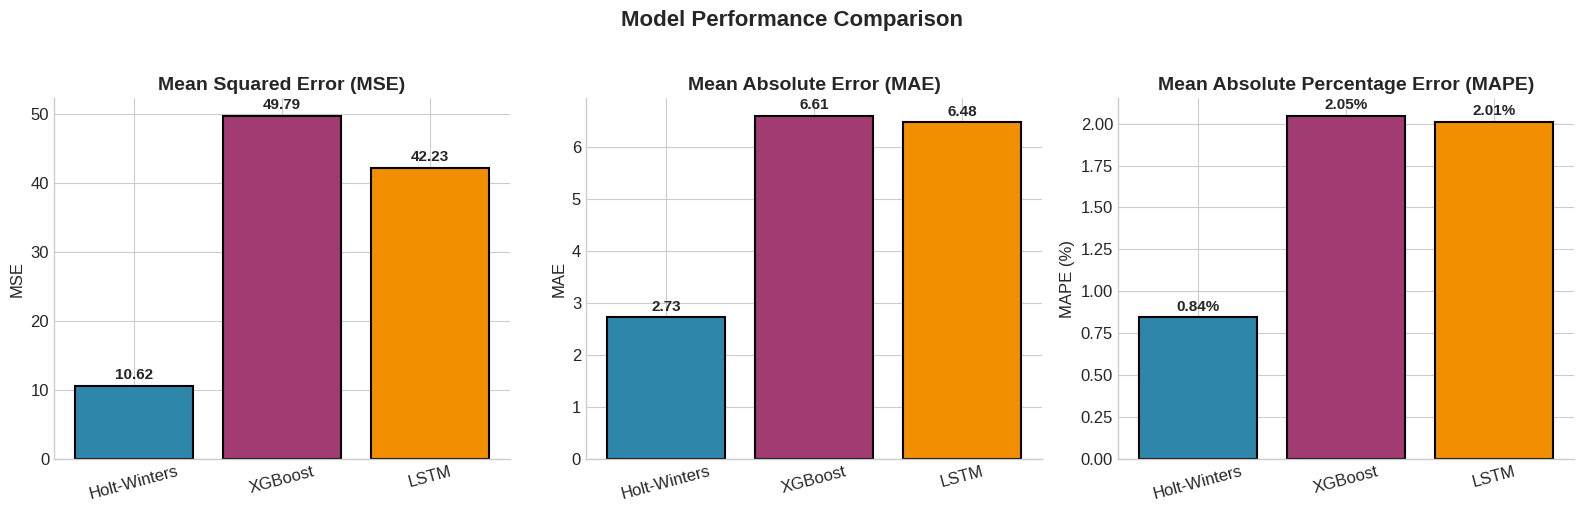

📈 Figure saved: figures/07_model_comparison.png


In [24]:
# Professional model comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['Holt-Winters', 'XGBoost', 'LSTM']
colors = [COLORS['primary'], COLORS['secondary'], COLORS['accent']]

# MSE
bars1 = axes[0].bar(models, [mse_hw, mse_xgb, mse_lstm], color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE', fontsize=12)
for bar, val in zip(bars1, [mse_hw, mse_xgb, mse_lstm]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max([mse_hw, mse_xgb, mse_lstm]),
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# MAE
bars2 = axes[1].bar(models, [mae_hw, mae_xgb, mae_lstm], color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12)
for bar, val in zip(bars2, [mae_hw, mae_xgb, mae_lstm]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max([mae_hw, mae_xgb, mae_lstm]),
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# MAPE
bars3 = axes[2].bar(models, [mape_hw, mape_xgb, mape_lstm], color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAPE (%)', fontsize=12)
for bar, val in zip(bars3, [mape_hw, mape_xgb, mape_lstm]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max([mape_hw, mape_xgb, mape_lstm]),
                f'{val:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/07_model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/07_model_comparison.png")

### 6.3 Forecast vs Actual Comparison

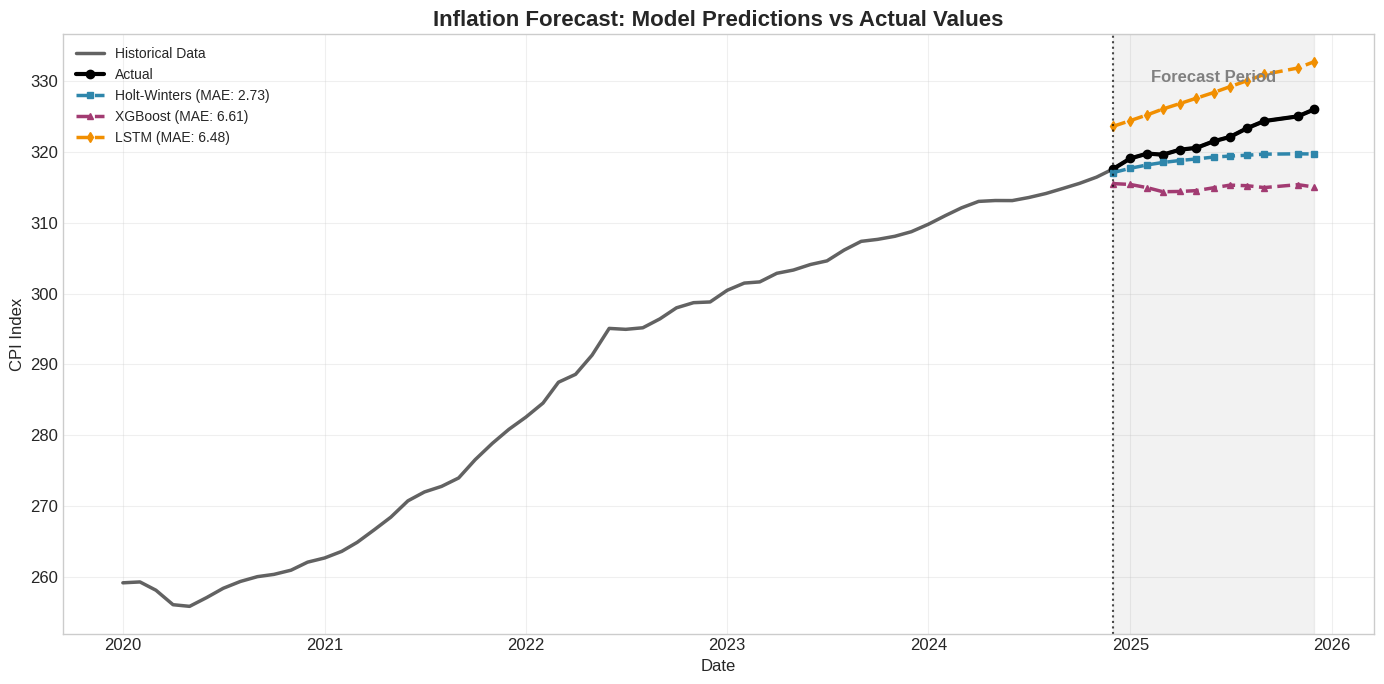

📈 Figure saved: figures/08_forecast_comparison.png


In [25]:
# Comprehensive forecast comparison plot
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data (last 3 years for context)
historical_recent = inflation_ts[inflation_ts.index >= '2020-01-01']
ax.plot(historical_recent.index, historical_recent, color=COLORS['dark'],
        linewidth=2.5, label='Historical Data', alpha=0.8)

# Actual test data
ax.plot(test_data.index, test_data, color='black', linewidth=3,
        label='Actual', linestyle='-', marker='o', markersize=6)

# Model predictions
ax.plot(test_data.index, hw_predictions, color=COLORS['primary'],
        linewidth=2.5, label=f'Holt-Winters (MAE: {mae_hw:.2f})', linestyle='--', marker='s', markersize=5)
ax.plot(y_test.index, xgb_predictions, color=COLORS['secondary'],
        linewidth=2.5, label=f'XGBoost (MAE: {mae_xgb:.2f})', linestyle='--', marker='^', markersize=5)
ax.plot(test_data.index, lstm_predictions, color=COLORS['accent'],
        linewidth=2.5, label=f'LSTM (MAE: {mae_lstm:.2f})', linestyle='--', marker='d', markersize=5)

# Shade forecast period
ax.axvspan(test_data.index[0], test_data.index[-1], alpha=0.1, color='gray')
ax.axvline(x=test_data.index[0], color='black', linestyle=':', linewidth=1.5, alpha=0.7)

# Add text annotation
ax.annotate('Forecast Period', xy=(test_data.index[len(test_data)//2], ax.get_ylim()[1]*0.98),
           fontsize=12, ha='center', fontweight='bold', color='gray')

ax.set_title('Inflation Forecast: Model Predictions vs Actual Values', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CPI Index', fontsize=12)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/08_forecast_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/08_forecast_comparison.png")

### 6.4 XGBoost Feature Importance

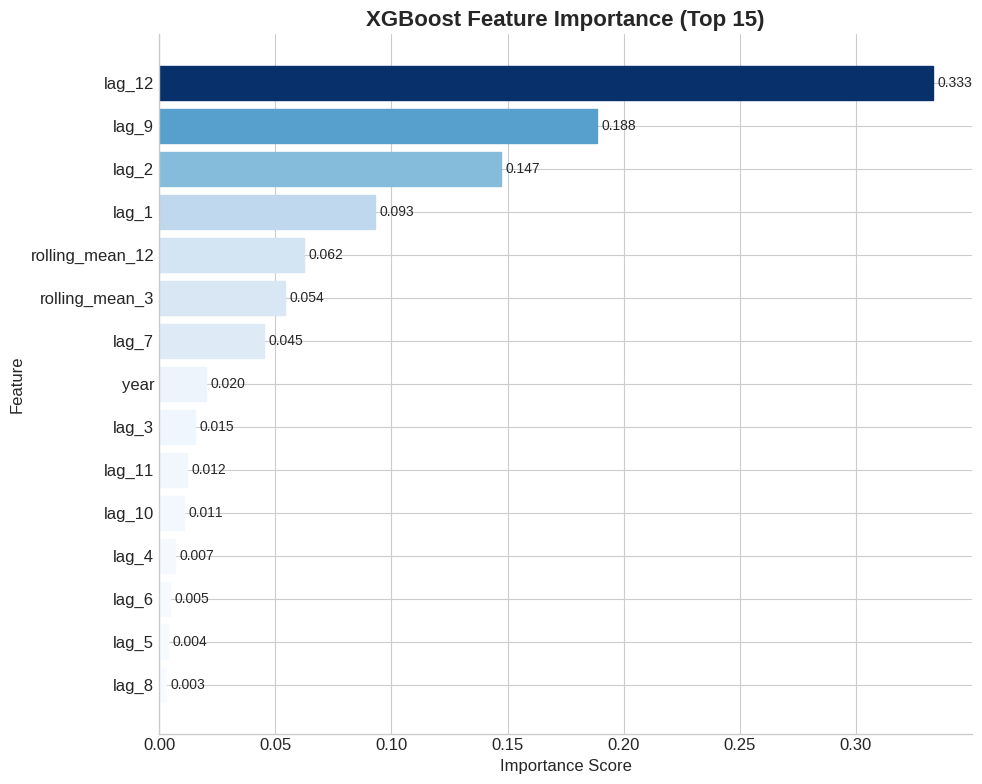

📈 Figure saved: figures/09_feature_importance.png


In [26]:
# Feature importance plot for XGBoost
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)  # Top 15 features

fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_df['Feature'], importance_df['Importance'],
               color=COLORS['primary'], edgecolor='black', linewidth=1)

# Color gradient for bars
norm = plt.Normalize(importance_df['Importance'].min(), importance_df['Importance'].max())
colors = plt.cm.Blues(norm(importance_df['Importance']))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_title('XGBoost Feature Importance (Top 15)', fontsize=16, fontweight='bold')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for i, (idx, row) in enumerate(importance_df.iterrows()):
    ax.text(row['Importance'] + 0.002, i, f'{row["Importance"]:.3f}',
           va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/09_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/09_feature_importance.png")

### 6.5 Residual Analysis

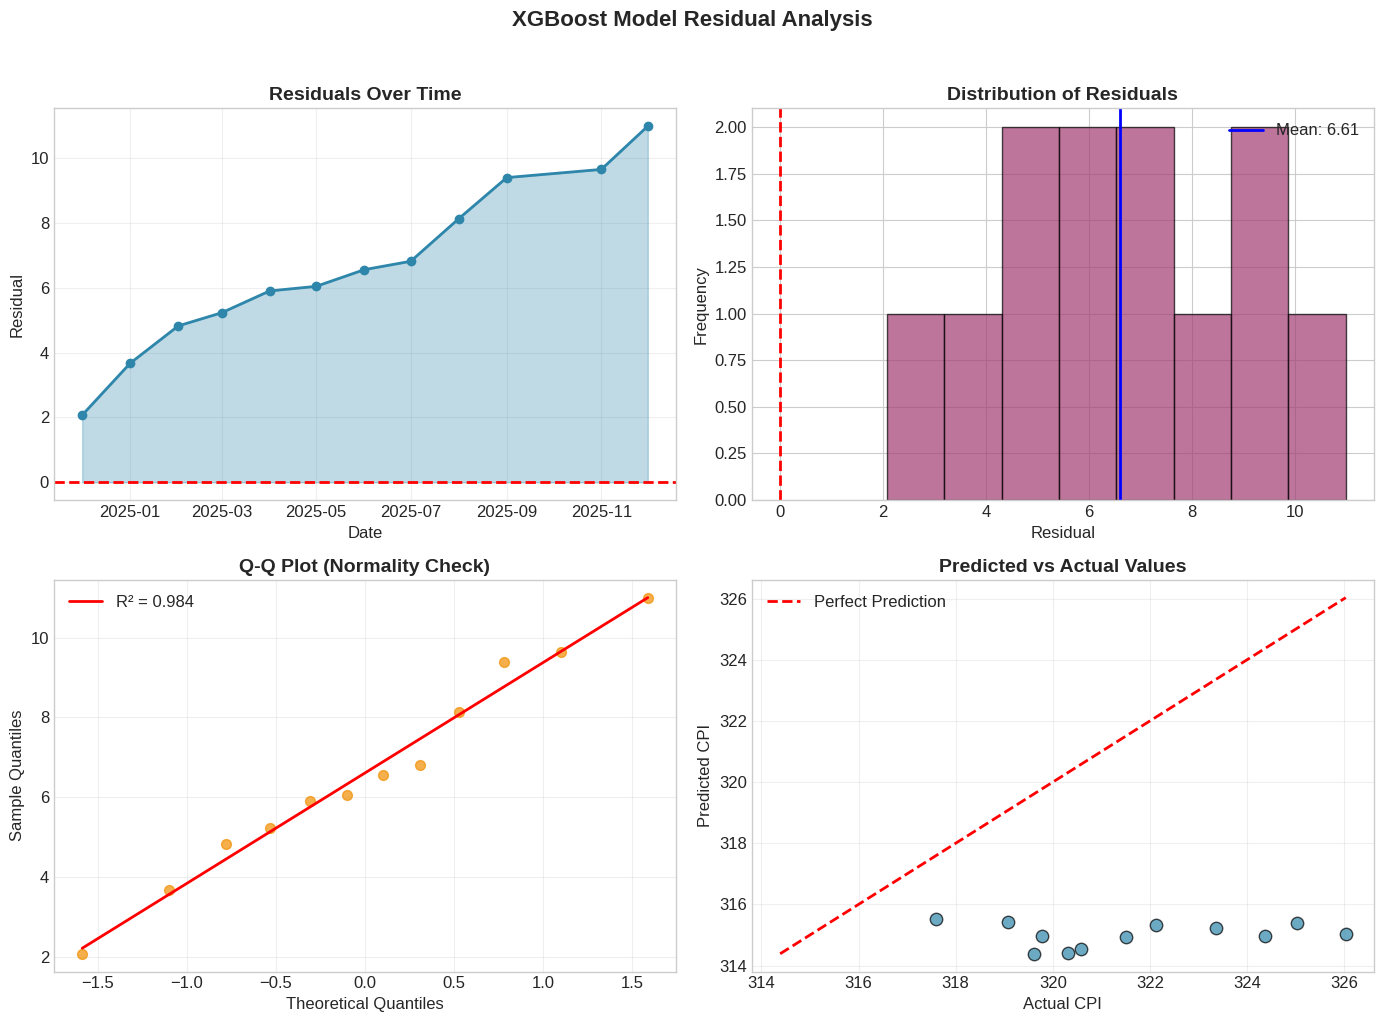

📈 Figure saved: figures/10_residual_analysis.png


In [27]:
# Residual analysis for best model (XGBoost)
residuals_xgb = y_test.values - xgb_predictions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(y_test.index, residuals_xgb, color=COLORS['primary'], marker='o', linewidth=2)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].fill_between(y_test.index, residuals_xgb, 0, alpha=0.3, color=COLORS['primary'])
axes[0, 0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals_xgb, bins=8, color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=np.mean(residuals_xgb), color='blue', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_xgb):.2f}')
axes[0, 1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Q-Q Plot
from scipy import stats
(osm, osr), (slope, intercept, r) = stats.probplot(residuals_xgb, dist="norm")
axes[1, 0].scatter(osm, osr, color=COLORS['accent'], s=50, alpha=0.7)
axes[1, 0].plot(osm, slope*osm + intercept, color='red', linewidth=2, label=f'R² = {r**2:.3f}')
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Theoretical Quantiles')
axes[1, 0].set_ylabel('Sample Quantiles')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Predicted vs Actual
axes[1, 1].scatter(y_test.values, xgb_predictions, color=COLORS['primary'], s=80, alpha=0.7, edgecolor='black')
min_val = min(y_test.min(), xgb_predictions.min())
max_val = max(y_test.max(), xgb_predictions.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title('Predicted vs Actual Values', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual CPI')
axes[1, 1].set_ylabel('Predicted CPI')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('XGBoost Model Residual Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/10_residual_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/10_residual_analysis.png")

### 6.6 LSTM Training History

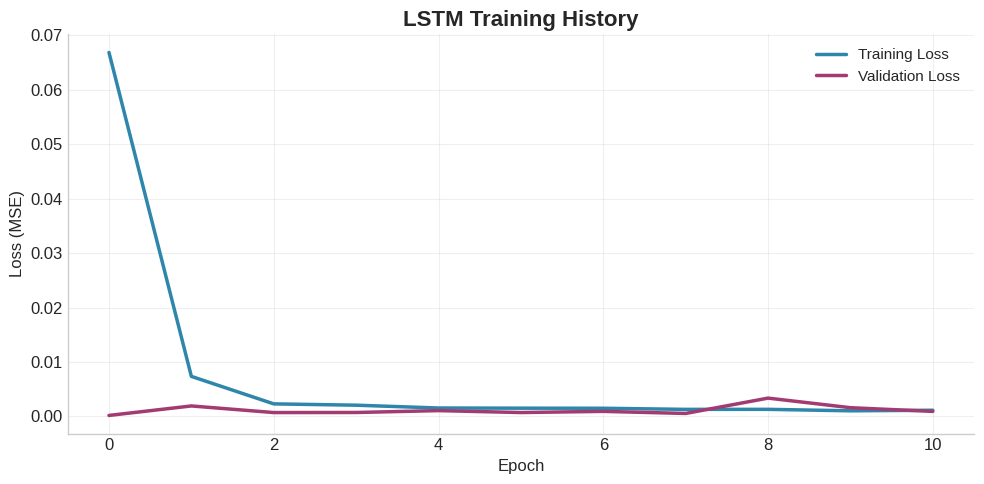

📈 Figure saved: figures/11_lstm_training.png


In [28]:
# LSTM Training Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history.history['loss'], color=COLORS['primary'], linewidth=2.5, label='Training Loss')
ax.plot(history.history['val_loss'], color=COLORS['secondary'], linewidth=2.5, label='Validation Loss')

ax.set_title('LSTM Training History', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/11_lstm_training.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("📈 Figure saved: figures/11_lstm_training.png")

## 7. Summary and Conclusions

In [29]:
# Final summary
print("="*70)
print("                    📊 FINAL MODEL SUMMARY")
print("="*70)
print(f"\n📈 Best Model: {best_model}")
print(f"\n🎯 Performance Metrics:")
print(results.to_string(index=False))
print(f"\n📁 Figures generated and saved to 'figures/' directory:")
print("   01. Historical CPI Trend with Economic Events")
print("   02. Year-over-Year Inflation Rate")
print("   03. Seasonal Decomposition")
print("   04. Correlation Heatmap")
print("   05. ACF/PACF Plots")
print("   06. Train/Test Split Visualization")
print("   07. Model Performance Comparison")
print("   08. Forecast vs Actual Comparison")
print("   09. XGBoost Feature Importance")
print("   10. Residual Analysis")
print("   11. LSTM Training History")
print("\n" + "="*70)
print("            Project by Jason Finkle | github.com/jfinkle00")
print("="*70)

                    📊 FINAL MODEL SUMMARY

📈 Best Model: Holt-Winters

🎯 Performance Metrics:
       Model       MSE      MAE  MAPE (%) Best
Holt-Winters 10.618194 2.728300  0.844161    ⭐
     XGBoost 49.786913 6.606845  2.048483     
        LSTM 42.227100 6.475006  2.012630     

📁 Figures generated and saved to 'figures/' directory:
   01. Historical CPI Trend with Economic Events
   02. Year-over-Year Inflation Rate
   03. Seasonal Decomposition
   04. Correlation Heatmap
   05. ACF/PACF Plots
   06. Train/Test Split Visualization
   07. Model Performance Comparison
   08. Forecast vs Actual Comparison
   09. XGBoost Feature Importance
   10. Residual Analysis
   11. LSTM Training History

            Project by Jason Finkle | github.com/jfinkle00
